<a href="https://colab.research.google.com/github/Meridor6919/BeeClassification/blob/Functional-API/BeeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [4]:
dataset = tfds.load('bee_dataset', split=['train'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7490 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0.incompletePEYE4F/bee_dataset-train.tfrecord*…

Dataset bee_dataset downloaded and prepared to ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Split between training data, validation data, test data
splitSize = (0.0, 0.765, 0.9, 1.0)

array = np.vstack(list(tfds.as_numpy(dataset[0])))

ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
    return (
        np.array(list(map(lambda x: x[0][:, :, 0], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['cooling_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['pollen_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['varroa_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['wasps_output'], array[ranges[idx]: ranges[idx + 1]])))
    )

# 0 - train, 1 - validation, 2 - test
   
_input = keras.Input(shape=(300, 150, 1), name="img")
x = layers.Conv2D(256, (3, 3), activation='relu')(_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='tanh')(x)
_output = layers.Dense(4)(x)


# wszystkie dane na raz (z 4 parametrow robimy wektory czteroelementowe)
labels_all = [None] * 3
images = [None] *3 
for i in range(3):
    helper = getDataset(ranges, i)
    images[i] = helper[0]
    labels_all[i] = np.column_stack((helper[1], helper[2], helper[3], helper[4]))

#print(str(labels_all[0].shape))
#print(str(labels_all[1].shape))

model_all = keras.Model(_input, _output, name="model_all")
# model_all.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# tf.keras.losses.CategoricalCrossentropy()
model_all.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_all = model_all.fit(images[0], labels_all[0], validation_data=(images[1], labels_all[1]), epochs=30)


print(max(history_all.history['accuracy']))

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Epoch 1/30
180/180 [==============================] - 52s 228ms/step - loss: 0.7940 - accuracy: 0.3491 - val_loss: 0.8085 - val_accuracy: 0.1344
Epoch 2/30
180/180 [==============================] - 40s 224ms/step - loss: 0.7615 - accuracy: 0.4140 - val_loss: 0.7816 - val_accuracy: 0.3528
Epoch 3/30
180/180 [==============================] - 42s 232ms/step - loss: 0.7090 - accuracy: 0.4392 - val_loss: 0.6859 - val_accuracy: 0.4822
Epoch 4/30
180/180 [==============================] - 41s 229ms/step - loss: 0.6197 - accuracy: 0.5072 - val_loss: 0.5994 - val_accuracy: 0.5306
Epoch 5/30
180/180 [==============================] - 41s 230ms/step - loss: 0.5663 - accuracy: 0.5168 - val_loss: 0.5780 - val_accuracy: 0.5356
Epoch 6/30
180/180 [==============================] - 41s 230ms/step - loss: 0.5410 - accuracy: 0.5202 - val_loss: 0.5508 - val_accuracy: 0.5395
Epoch 7/30
180/180 [==============================] - 41s 229ms/step - loss: 0.5253 - accuracy: 0.5168 - val_loss: 0.5569 - val_ac

In [14]:
history_test = model_all.evaluate(images[2], labels_all[2])

24/24 [==============================] - 2s 82ms/step - loss: 0.3983 - accuracy: 0.5728


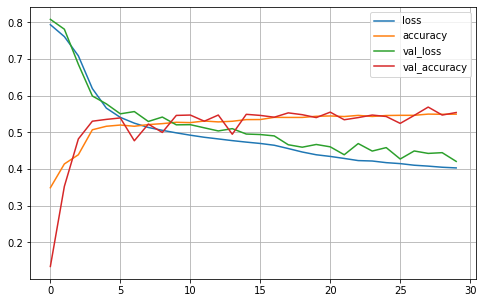

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history_all.history).plot(figsize=(8, 5))
plt.grid(True)

In [24]:
_input = keras.Input(shape=(300, 150, 1), name="img")
x = layers.Conv2D(32, (3, 3), activation='relu')(_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(62, (3, 3), activation='tanh')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='tanh')(x)
_output = layers.Dense(4)(x)


# wszystkie dane na raz (z 4 parametrow robimy wektory czteroelementowe)
labels_all = [None] * 3
images = [None] *3 
for i in range(3):
    helper = getDataset(ranges, i)
    images[i] = helper[0]
    labels_all[i] = np.column_stack((helper[1], helper[2], helper[3], helper[4]))

model_all = keras.Model(_input, _output, name="model_all")

model_all.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_all = model_all.fit(images[0], labels_all[0], validation_data=(images[1], labels_all[1]), epochs=10)

print(max(history_all.history['accuracy']))

Epoch 1/10
180/180 [==============================] - 13s 63ms/step - loss: 0.7591 - accuracy: 0.4558 - val_loss: 0.8211 - val_accuracy: 0.1433
Epoch 2/10
180/180 [==============================] - 11s 59ms/step - loss: 0.6374 - accuracy: 0.5505 - val_loss: 0.6379 - val_accuracy: 0.6630
Epoch 3/10
180/180 [==============================] - 11s 59ms/step - loss: 0.5479 - accuracy: 0.5502 - val_loss: 0.5729 - val_accuracy: 0.5593
Epoch 4/10
180/180 [==============================] - 11s 59ms/step - loss: 0.4857 - accuracy: 0.5655 - val_loss: 0.5329 - val_accuracy: 0.5089
Epoch 5/10
180/180 [==============================] - 11s 59ms/step - loss: 0.4477 - accuracy: 0.5717 - val_loss: 0.4877 - val_accuracy: 0.5208
Epoch 6/10
180/180 [==============================] - 11s 59ms/step - loss: 0.4211 - accuracy: 0.5729 - val_loss: 0.4897 - val_accuracy: 0.6383
Epoch 7/10
180/180 [==============================] - 11s 59ms/step - loss: 0.4020 - accuracy: 0.5785 - val_loss: 0.4352 - val_accuracy:

In [25]:
history_test = model_all.evaluate(images[2], labels_all[2])

24/24 [==============================] - 1s 27ms/step - loss: 0.4665 - accuracy: 0.6929


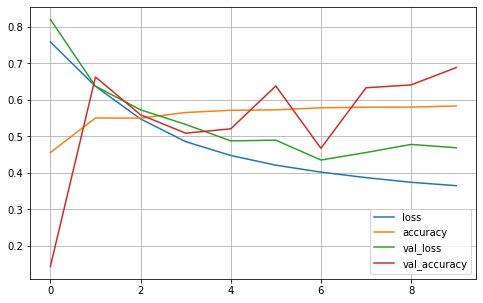

In [26]:
pd.DataFrame(history_all.history).plot(figsize=(8, 5))
plt.grid(True)

In [28]:
_input = keras.Input(shape=(300, 150, 1), name="img")
x = layers.Conv2D(32, (3, 3), activation='relu')(_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(62, (3, 3), activation='tanh')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='tanh')(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='tanh')(x)
_output = layers.Dense(4)(x)


# wszystkie dane na raz (z 4 parametrow robimy wektory czteroelementowe)
labels_all = [None] * 3
images = [None] *3 
for i in range(3):
    helper = getDataset(ranges, i)
    images[i] = helper[0]
    labels_all[i] = np.column_stack((helper[1], helper[2], helper[3], helper[4]))

model_all = keras.Model(_input, _output, name="model_all")

model_all.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_all = model_all.fit(images[0], labels_all[0], validation_data=(images[1], labels_all[1]), epochs=30)

print(max(history_all.history['accuracy']))

Epoch 1/30
180/180 [==============================] - 12s 62ms/step - loss: 0.8176 - accuracy: 0.3624 - val_loss: 0.8226 - val_accuracy: 0.5731
Epoch 2/30
180/180 [==============================] - 11s 62ms/step - loss: 0.7941 - accuracy: 0.3444 - val_loss: 0.8325 - val_accuracy: 0.5741
Epoch 3/30
180/180 [==============================] - 11s 63ms/step - loss: 0.7820 - accuracy: 0.3702 - val_loss: 0.7823 - val_accuracy: 0.3330
Epoch 4/30
180/180 [==============================] - 11s 62ms/step - loss: 0.7492 - accuracy: 0.4366 - val_loss: 0.7521 - val_accuracy: 0.2530
Epoch 5/30
180/180 [==============================] - 11s 63ms/step - loss: 0.7091 - accuracy: 0.4624 - val_loss: 0.6824 - val_accuracy: 0.4704
Epoch 6/30
180/180 [==============================] - 11s 61ms/step - loss: 0.6689 - accuracy: 0.4893 - val_loss: 0.6691 - val_accuracy: 0.3834
Epoch 7/30
180/180 [==============================] - 11s 61ms/step - loss: 0.6295 - accuracy: 0.5139 - val_loss: 0.6134 - val_accuracy:

In [29]:
history_test = model_all.evaluate(images[2], labels_all[2])

24/24 [==============================] - 0s 19ms/step - loss: 0.3872 - accuracy: 0.5661


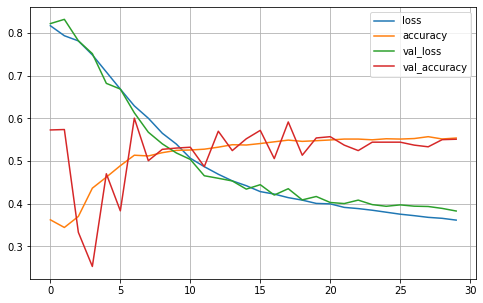

In [30]:
pd.DataFrame(history_all.history).plot(figsize=(8, 5))
plt.grid(True)